In [100]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

Считываем тренировочные и тестовые данные, заполняем пробелы

In [101]:
train= "../input/titanic/train.csv"
test = "../input/titanic/test.csv"

df_tr = pd.read_csv(train)
df_te = pd.read_csv(test)


train_random_ages = np.random.randint(df_tr["Age"].mean() - df_tr["Age"].std(), df_tr["Age"].mean() + df_tr["Age"].std(),
size = df_tr["Age"].isnull().sum())
test_random_ages = np.random.randint(df_te["Age"].mean() - df_te["Age"].std(),df_te["Age"].mean() + df_te["Age"].std(),
size = df_te["Age"].isnull().sum())

pd.options.mode.chained_assignment = None
df_tr["Age"][np.isnan(df_tr["Age"])] = train_random_ages
df_te["Age"][np.isnan(df_te["Age"])] = test_random_ages
df_tr['Sex'] = np.where(df_tr['Sex'] == 'male', 0, df_tr['Sex'])
df_tr['Sex'] = np.where(df_tr['Sex'] == 'female', 1, df_tr['Sex'])
df_te['Sex'] = np.where(df_te['Sex'] == 'male', 0, df_te['Sex'])
df_te['Sex'] = np.where(df_te['Sex'] == 'female', 1, df_te['Sex'])
df_tr['Embarked'] = np.where(df_tr['Embarked'] == 'C', 1, df_tr['Embarked'])
df_tr['Embarked'] = np.where(df_tr['Embarked'] == 'Q', 2, df_tr['Embarked'])
df_tr['Embarked'] = np.where(df_tr['Embarked'] == 'S', 3, df_tr['Embarked'])
df_te['Embarked'] = np.where(df_te['Embarked'] == 'C', 1, df_te['Embarked'])
df_te['Embarked'] = np.where(df_te['Embarked'] == 'Q', 2, df_te['Embarked'])
df_te['Embarked'] = np.where(df_te['Embarked'] == 'S', 3, df_te['Embarked'])
df_tr["Embarked"].fillna('0', inplace=True)
df_te["Embarked"].fillna('0', inplace=True)
df_tr["Fare"].fillna(df_tr["Fare"].median(), inplace=True)
df_te["Fare"].fillna(df_te["Fare"].median(), inplace=True)
df_tr['CabinStatus'] = df_tr["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df_te['CabinStatus'] = df_te["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

df_tr['Age'] = df_tr['Age'].astype(int)
df_te['Age'] = df_te['Age'].astype(int)
df_tr['Sex'] = df_tr['Sex'].astype(int)
df_te['Sex'] = df_te['Sex'].astype(int)
df_tr['Embarked'] = df_tr['Embarked'].astype(int)
df_te['Embarked'] = df_te['Embarked'].astype(int)

Отображаем корреляцию данных. Шанс выживания напрямую сильно коррелируется с полом, ценой билета, наличие кабины и класс проживания  (чем выше номер класса, тем ниже шанс выживания).

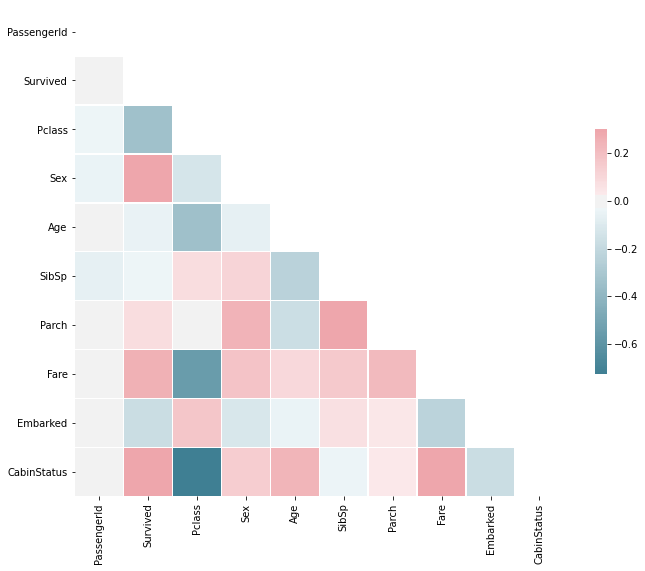

In [102]:
corr = df_tr.corr()


mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns_plot =sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

pic = sns_plot.get_figure()

Разделяем определенные данные на категории, убираем лишние данные

In [103]:
df_tr["Age"] = np.where(df_tr['Age'] < 14, 0, df_tr['Age'])
df_tr["Age"] = np.where((df_tr['Age'] >= 14) & (df_tr['Age'] < 21), 1, df_tr['Age'])
df_tr["Age"] = np.where((df_tr['Age'] >= 21) & (df_tr['Age'] < 60), 2, df_tr['Age'])
df_tr["Age"] = np.where(df_tr['Age'] >= 60, 3, df_tr['Age'])
df_te["Age"] = np.where(df_te['Age'] < 14, 0, df_te['Age'])
df_te["Age"] = np.where((df_te['Age'] >= 14) & (df_te['Age'] < 21), 1, df_te['Age'])
df_te["Age"] = np.where((df_te['Age'] >= 21) & (df_te['Age'] < 60), 2, df_te['Age'])
df_te["Age"] = np.where(df_te['Age'] >= 60, 3, df_te['Age'])
df_tr['SibSp'] = np.where((df_tr['SibSp'] >= 1) & (df_tr['SibSp'] <= 2), 1, df_tr['SibSp'])
df_tr['SibSp'] = np.where(df_tr['SibSp'] > 2, 2, df_tr['SibSp'])
df_te['SibSp'] = np.where((df_te['SibSp'] >= 1) & (df_te['SibSp'] <= 2), 1, df_te['SibSp'])
df_te['SibSp'] = np.where(df_te['SibSp'] > 2, 2, df_te['SibSp'])
df_tr['Parch'] = np.where((df_tr['Parch'] >= 1) & (df_tr['Parch'] <= 2), 1, df_tr['Parch'])
df_tr['Parch'] = np.where(df_tr['Parch'] > 2, 2, df_tr['Parch'])
df_te['Parch'] = np.where((df_te['Parch'] >= 1) & (df_te['Parch'] <= 2), 1, df_te['Parch'])
df_te['Parch'] = np.where(df_te['Parch'] > 2, 2, df_te['Parch'])
df_tr["Fare"] = np.where(df_tr['Fare'] < 8, 0, df_tr['Fare'])
df_tr["Fare"] = np.where((df_tr['Fare'] >= 8) & (df_tr['Fare'] < 15), 1, df_tr['Fare'])
df_tr["Fare"] = np.where((df_tr['Fare'] >= 15) & (df_tr['Fare'] < 31), 2, df_tr['Fare'])
df_tr["Fare"] = np.where(df_tr['Fare'] >= 31, 3, df_tr['Fare'])
df_te["Fare"] = np.where(df_te['Fare'] < 8, 0, df_te['Fare'])
df_te["Fare"] = np.where((df_te['Fare'] >= 8) & (df_te['Fare'] < 15), 1, df_te['Fare'])
df_te["Fare"] = np.where((df_te['Fare'] >= 15) & (df_te['Fare'] < 31), 2, df_te['Fare'])
df_te["Fare"] = np.where(df_te['Fare'] >= 31, 3, df_te['Fare'])

df_tr['Age'] = df_tr['Age'].astype(int)
df_te['Age'] = df_te['Age'].astype(int)
df_tr['Sex'] = df_tr['Sex'].astype(int)
df_te['Sex'] = df_te['Sex'].astype(int)
df_tr['SibSp'] = df_tr['SibSp'].astype(int)
df_te['SibSp'] = df_te['SibSp'].astype(int)
df_tr['Parch'] = df_tr['Parch'].astype(int)
df_te['Parch'] = df_te['Parch'].astype(int)
df_tr['Fare'] = df_tr['Fare'].astype(int)
df_te['Fare'] = df_te['Fare'].astype(int)
df_tr['CabinStatus'] = df_tr['CabinStatus'].astype(int)
df_te['CabinStatus'] = df_te['CabinStatus'].astype(int)

del df_tr['Name']
del df_te['Name']
del df_tr['Cabin']
del df_te['Cabin']
del df_tr['Ticket']
del df_te['Ticket']

Создаем тренировочный датасет (без выживания), и датасет только с выживанием.

In [104]:
del df_tr['PassengerId']

train_nosurvive = df_tr.drop("Survived",axis=1)
train_survive = df_tr["Survived"]
test_nosurvive = df_te.drop("PassengerId",axis=1).copy()


Предсказываем выживание в тестовом датасете с помощью наивно байесовского алгоритма, проверяем точность метода

In [105]:
pred = gnb.fit(train_nosurvive, train_survive).predict(test_nosurvive)

result_tr = gnb.score(train_nosurvive, train_survive)
result_val = cross_val_score(gnb,train_nosurvive, train_survive, cv=5).mean()
print(result_tr , result_val)

0.7519640852974186 0.7498085493691544


In [106]:

finalresult = pd.DataFrame({"PassengerId": df_te["PassengerId"],"Survived": pred})
finalresult.to_csv('titanic.csv', index=False)